# Investigate a Relational Database

This script uses `SQL` and `sqlalchemy` to explore a database related to movie rentals.

This script has 5 parts, each with the following:
- Question of interest about the database
- Supporting SQL query needed to answer the question
- Supporting visualization(s) created using the final data of the SQL query that answers your question of interest

In this project, you will query the Sakila DVD Rental database. The Sakila Database holds information about a company that rents movie DVDs. For this project, you will be querying the database to gain an understanding of the customer base, such as what the patterns in movie watching are across different customer groups, how they compare on payment earnings, and how the stores compare in their performance. To assist you in the queries ahead, the schema for the DVD Rental database is provided below

![image](dvd-rental-erd.png)

In [1]:
# Import dependencies
import pandas as pd
from sqlalchemy import create_engine
import psycopg2
import matplotlib.pyplot as plt
import numpy as np
from databaseconfig import user_name, password, local_host
import seaborn as sns
import datetime

In [2]:
# Connect to postgres
engine = create_engine(f'postgresql://{user_name}:{password}@{local_host}/dvdrental')
connection = engine.connect()

-----
# Question 1
#### **Out of all of the family movies, what are the categories of those movies and how many times has it been rented out?**

For the first question, the aim is to understand more about the movies that families are watching. The following categories are considered family movies: Animation, Children, Classics, Comedy, Family and Music.

#### Below creates a query that lists each movie, the film category it is classified in, and the number of times it has been rented out.

In [3]:
fam_rentals_query = "select \
    f.title as film_title,\
    c.name as category_name,\
    count(r.rental_date) as rental_count \
from film_category as fc \
join category as c \
on c.category_id = fc.category_id \
join film as f \
on f.film_id = fc.film_id \
join inventory as i \
on fc.film_id = i.film_id \
join rental as r \
on r.inventory_id = i.inventory_id \
    where c.name = 'Animation' \
    or c.name = 'Children' \
    or c.name = 'Classics' \
    or c.name = 'Comedy' \
    or c.name = 'Family' \
    or c.name = 'Music' \
group by film_title, category_name \
order by 2,1;"

# Store the returned query to a DataFrame
fam_rental_movies = pd.read_sql_query(fam_rentals_query, con=engine)
fam_rental_movies.head()

,film_title,category_name,rental_count
0,Alter Victory,Animation,22
1,Anaconda Confessions,Animation,21
2,Bikini Borrowers,Animation,17
3,Blackout Private,Animation,27
4,Borrowers Bedazzled,Animation,22


#### Plot the total family movie rentals per category

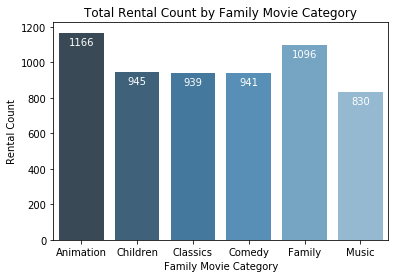

In [4]:
# Get the unique category names in the DataFrame
unique_cats = list(fam_rental_movies['category_name'].unique())

# Count the sum of family movie rentals per category
cat_counts = [fam_rental_movies.loc[fam_rental_movies['category_name']==u]['rental_count'].sum() for u in unique_cats]

# Plot a bar chart of the sum of family movie rentals per category
sns.barplot(unique_cats,cat_counts,palette="Blues_d")
plt.xlabel('Family Movie Category')
plt.ylabel('Rental Count')
plt.title('Total Rental Count by Family Movie Category')

# Include the rental count on the bars in the bar chart
for i in range(0,len(cat_counts)):
    text = cat_counts[i]
    pos = int(text-80)
    plt.text(i,pos,text,color='white',ha='center',va='bottom')

# Save the graph
plt.savefig('Visualizations/Q1_FamilyRentalCountByCategory.png')
plt.show()

#### Plot the top 10 family movies rented out and their respective categories

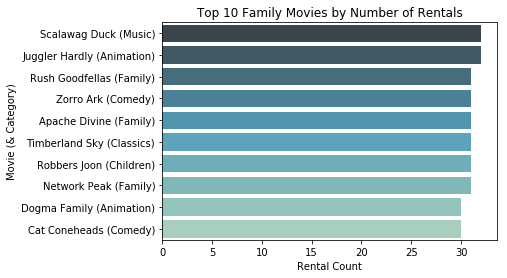

In [5]:
top10_fam = fam_rental_movies.copy()
top10_fam = top10_fam.sort_values('rental_count',ascending=False)[0:10]

# Plot a bar chart of the top 10 family movies rented out, and the rental count for each of the 10 movies
sns.barplot(top10_fam['rental_count'],top10_fam['film_title'],palette="GnBu_d")
plt.title('Top 10 Family Movies by Number of Rentals')
plt.xlabel('Rental Count')
plt.ylabel('Movie (& Category)')

# Set the title and the category for the y-axis ticks
plt.yticks(ticks = range(0,len(top10_fam)),labels=[f'{title} ({top10_fam["category_name"].values[i]})' for i,title in enumerate(top10_fam['film_title'])])         

# Save the graph
plt.savefig('Visualizations/Q1_Top10FamilyMoviesRented.png', bbox_inches = "tight")
plt.show()  

#### Plot the top 20 family movies rented out and their respective categories

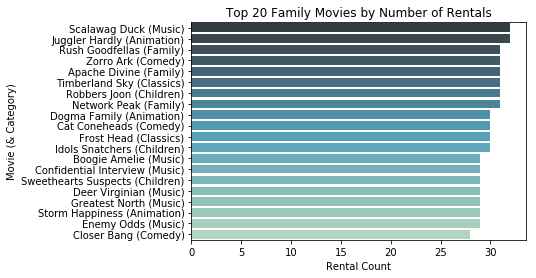

In [6]:
top20_fam = fam_rental_movies.copy()
top20_fam = top20_fam.sort_values('rental_count',ascending=False)[0:20]

# Plot a bar chart of the top 10 family movies rented out, and the rental count for each of the 10 movies
sns.barplot(top20_fam['rental_count'],top20_fam['film_title'],palette="GnBu_d")
plt.title('Top 20 Family Movies by Number of Rentals')
plt.xlabel('Rental Count')
plt.ylabel('Movie (& Category)')
plt.yticks(ticks = range(0,len(top20_fam)),labels=[f'{title} ({top20_fam["category_name"].values[i]})' for i,title in enumerate(top20_fam['film_title'])])

# Save the graph
plt.savefig('Visualizations/Q1_Top20FamilyMoviesRented.png', bbox_inches = "tight")
plt.show()

#### Question 1 Discussion:
Out of all of the the family movie categories, *Animation* has the highest rentals with `1,166` rentals. The second highest rentals are *Family* movies with `1,096` rentals. *Music* has the lowest rentals with `830` rentals. *Children*, *Classics*, and *Comedy* have similar counts in the range of `939` to `945`.

The top `10` family movie rentals are *Scalawag Duck*, *Juggler Hardly*, *Rush Goodfellas*, *Zorro Ark*, *Apache Divine*, *Timberland Sky*, *Robbers Joon*, *Network Peak*, *Dogma Family*, and *Cat Coneheads*. Out of these top `10` movies, the top rental is *Scalawag Duck* and it the only movie in the Music category. There are `2` *Animation* movies, `3` *Family* movies, `2` *Comedy* movies, `1` *Classics* movie, and `1` *Children* movie.

The top `20` family movie rentals include the above movies, and also include *Frost Head*, *Idols Snatchers*, *Boogie Amelie*, *Confidential Interview*, *Sweethearts Suspects*, *Deer Virginian*, *Greatest North*, *Storm Happiness*, *Enemy Odds*, and *Closer Bang*. Out of all of these top `20` family movies, `60%` of them are in the *Music* category, `30%` of them are in the *Children* category, `30%` of them are in the *Animation* category, `30%` of them are in the *Comedy* category, `30%` of them are in the *Family* category, and `20%` are in the *Classics* category.

----------
# Question 2
#### How does the length of rental duration of these family-friendly movies compare to the duration that all movies are rented for?

Below provides a table with the movie titles divided into `4` levels (first_quarter, second_quarter, third_quarter, and final_quarter) based on the quartiles (`25%`, `50%`, `75%`) of the rental duration for movies across all categories, as well as the category that these family-friendly movies fall into.

In [7]:
quartiles_fam_query = "SELECT f.title as film_title, \
        c.name as category_name, \
        f.rental_duration as rental_duration, \
        NTILE(4) OVER(ORDER BY f.rental_duration) as standard_quartile \
    FROM film_category AS fc \
    JOIN category AS c \
    ON c.category_id = fc.category_id \
    JOIN film AS f \
    ON f.film_id = fc.film_id \
    WHERE c.name IN ('Animation', 'Children','Classics','Comedy','Family','Music') \
    ORDER BY f.rental_duration;"
quartiles_fam = pd.read_sql_query(quartiles_fam_query, con=engine)
quartiles_fam.head()


,film_title,category_name,rental_duration,standard_quartile
0,Sweethearts Suspects,Children,3,1
1,Go Purple,Music,3,1
2,Bilko Anonymous,Family,3,1
3,Wait Cider,Animation,3,1
4,Daughter Madigan,Children,3,1


#### Plot a bar graph of the family film count for each rental duration

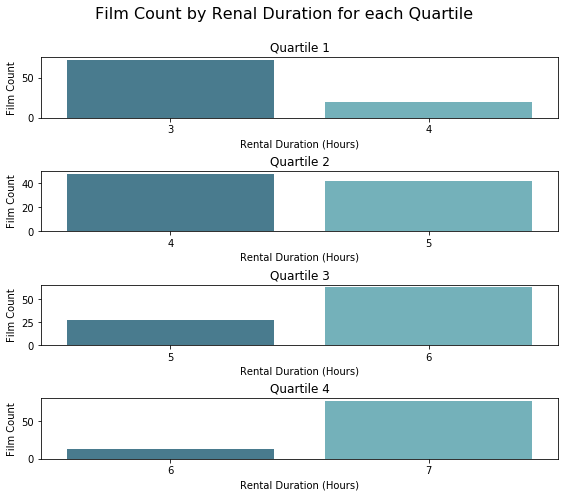

In [8]:
fig = plt.figure(figsize=(8,7))
fig.suptitle("Film Count by Renal Duration for each Quartile", fontsize=16)

for i in range(1,5):
    q1 = quartiles_fam.loc[quartiles_fam['standard_quartile']==i]['rental_duration'].value_counts()
    plt.subplot(4,1,i)
    sns.barplot(q1.index,q1.values,palette="GnBu_d")
    plt.xlabel('Rental Duration (Hours)')
    plt.ylabel('Film Count')
    plt.title(f'Quartile {i}')
plt.tight_layout()
fig.subplots_adjust(top=0.88)

# Save graph
plt.savefig('Visualizations/Q2_FamilyMovies_RentalDuration_Decomp.png', bbox_inches = "tight")
plt.show()

#### Plot a bar chart of the film count in each quartile

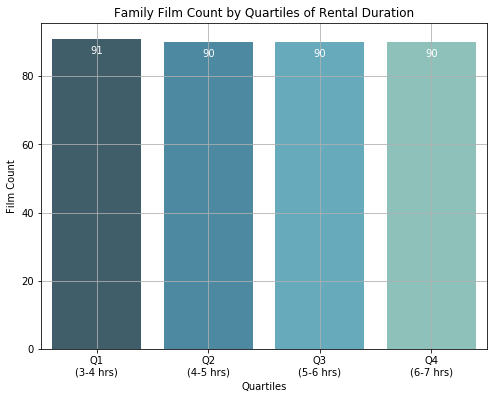

In [9]:
plt.figure(figsize=(8,6))
sns.barplot([f"Q1\n(3-4 hrs)",f"Q2\n(4-5 hrs)",f"Q3\n(5-6 hrs)",f"Q4\n(6-7 hrs)"],
            quartiles_fam['standard_quartile'].value_counts(),
            palette="GnBu_d")
plt.xlabel('Quartiles')
plt.ylabel('Film Count')
plt.title('Family Film Count by Quartiles of Rental Duration')
plt.grid()
for i in range(1,5):
    text = quartiles_fam['standard_quartile'].value_counts()[i]
    pos = text-5
    plt.text(i-1,pos,text,color='white',ha='center',va='bottom')
plt.savefig('Visualizations/Q2_FamilyMovies_RentalDurationQuartiles.png', bbox_inches = "tight")
plt.show()


#### Plot the number of movies in each quartile for non-family movies

In [10]:
non_fam_query = "SELECT f.title as film_title, \
        c.name as category_name, \
        f.rental_duration as rental_duration, \
        NTILE(4) OVER(ORDER BY f.rental_duration) as standard_quartile \
    FROM film_category AS fc \
    JOIN category AS c \
    ON c.category_id = fc.category_id \
    JOIN film AS f \
    ON f.film_id = fc.film_id \
    WHERE c.name NOT IN ('Animation', 'Children','Classics','Comedy','Family','Music') \
    ORDER BY f.rental_duration;"
non_fam_quart = pd.read_sql_query(non_fam_query, con=engine)
non_fam_quart.head()

,film_title,category_name,rental_duration,standard_quartile
0,High Encino,Horror,3,1
1,Tycoon Gathering,Games,3,1
2,Money Harold,New,3,1
3,Modern Dorado,Documentary,3,1
4,Tuxedo Mile,Sports,3,1


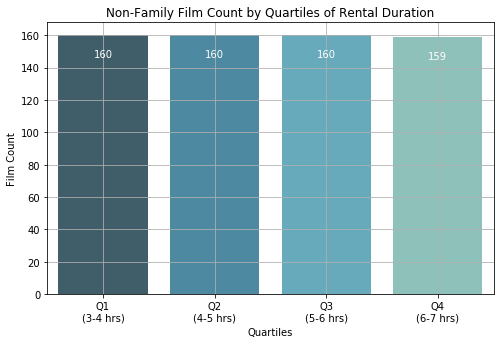

In [11]:
fam_vals = non_fam_quart['standard_quartile'].value_counts()
zipped = list(zip(fam_vals.index,fam_vals.values))
sort_zipped = sorted(zipped, key = lambda x: x[0])
quarts = [key for key,val in sort_zipped]
counts = [val for key,val in sort_zipped]

plt.figure(figsize=(8,5))
sns.barplot([f"Q1\n(3-4 hrs)",f"Q2\n(4-5 hrs)",f"Q3\n(5-6 hrs)",f"Q4\n(6-7 hrs)"],
            counts,
            palette="GnBu_d")
plt.xlabel('Quartiles')
plt.ylabel('Film Count')
plt.title('Non-Family Film Count by Quartiles of Rental Duration')
plt.grid()
for i in range(0,4):
    text = counts[i]
    pos = text-15
    plt.text(i,pos,text,color='white',ha='center',va='bottom')
plt.savefig('Visualizations/Q2_NONFamilyMovies_RentalDurationQuartiles.png', bbox_inches = "tight")

plt.show()

#### Plot the movie count by family category for Quartile 1

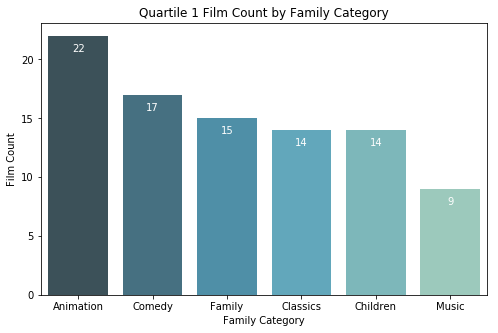

In [12]:
q1 = quartiles_fam.loc[quartiles_fam['standard_quartile']==1]['category_name'].value_counts()

plt.figure(figsize=(8,5))
sns.barplot(q1.index,q1.values,palette="GnBu_d")
plt.xlabel('Family Category')
plt.ylabel('Film Count')
plt.title('Quartile 1 Film Count by Family Category')
for i in range(0,len(q1)):
    text = q1.values[i]
    pos = text-1.5
    plt.text(i,pos,text,color='white',ha='center',va='bottom')

# Save graph
plt.savefig('Visualizations/Q2_FamilyMovies_RentalDurationQuartile1.png', bbox_inches = "tight")
plt.show()


#### Plot the movie count by family category for each quartile

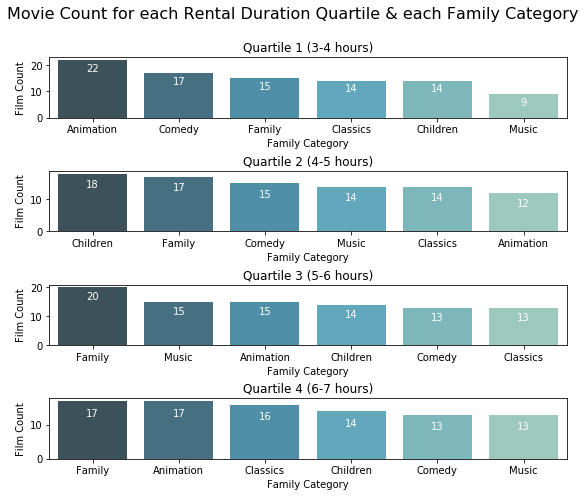

In [13]:
fig = plt.figure(figsize=(8,7))
fig.suptitle("Movie Count for each Rental Duration Quartile & each Family Category", fontsize=16)

for i in range(1,5):
    q1 = quartiles_fam.loc[quartiles_fam['standard_quartile']==i]['category_name'].value_counts()

    plt.subplot(4,1,i)
    sns.barplot(q1.index,q1.values,palette="GnBu_d")
    plt.xlabel('Family Category')
    plt.ylabel('Film Count')
    plt.title(f'Quartile {i} ({i+2}-{i+3} hours)')
    for j in range(0,len(q1)):
        text = q1.values[j]
        pos = text-5
        plt.text(j,pos,text,color='white',ha='center',va='bottom')
plt.tight_layout()
fig.subplots_adjust(top=0.88)

# Save graph
plt.savefig('Visualizations/Q2_FamilyMovies_RentalDurationQuartiles_Decomp.png', bbox_inches = "tight")
plt.show()

#### Question 2 Discussion:
There are `91` family movies in the first quartile, and `90` family movies in the second, third, and fourth quartile. 

For Quartile 1, the *Animation* category has the highest movie count (`22` movies) and the *Music* category has the lowest movie count (`9` movies). For Quartile 2, the *Children* category has the highest movie count (`18` movies) and the *Animation* category has the lowest movie count (`12` movies). For Quartile 3, the *Family* category has the highest movie count (`20` movies), and the *Classics* and *Comedy* categories have the lowest movie counts (`13` movies). For Quartile 4, the *Animation* and *Family* categories have the highest movie count (`17` movies), and the *Comedy* and *Music* categories have the lowest movie counts (`13` movies). 

The majority of movies rented in the 1st Quartile are rented for `3` hours, in the 2nd Quartile are rented for `4` hours, in the 3rd Quartile are rented for `6` hours, and in the 4th Quartile are rented for `7` hours.

-----
# Question 3
#### How many movies are within each combination of film category for each corresponding rental duration category?

The resulting table has three columns:

- Category
- Rental length category
- Count

The Count column is sorted first by Category and then by Rental Duration category.

In [14]:
fam_quartile_count_query = "SELECT category_name, standard_quartile, count(standard_quartile) as movie_count \
FROM \
(SELECT \
c.name as category_name, f.title, NTILE(4) OVER(ORDER BY f.rental_duration) AS standard_quartile \
FROM film_category AS fc \
JOIN category AS c \
ON c.category_id = fc.category_id \
JOIN film AS f \
ON f.film_id = fc.film_id \
WHERE c.name IN ('Animation', 'Children','Classics','Comedy','Family','Music')) f1 \
GROUP BY category_name,standard_quartile \
ORDER BY category_name,standard_quartile"
fam_quartile_count = pd.read_sql_query(fam_quartile_count_query, con=engine)
fam_quartile_count.head()

,category_name,standard_quartile,movie_count
0,Animation,1,22
1,Animation,2,12
2,Animation,3,15
3,Animation,4,17
4,Children,1,14


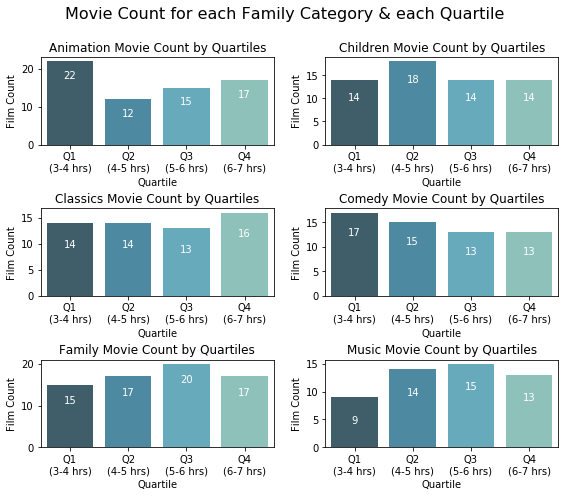

In [15]:
unique_cats = fam_quartile_count['category_name'].unique()
m=1
fig = plt.figure(figsize=(8,7))
fig.suptitle("Movie Count for each Family Category & each Quartile", fontsize=16)

for u in unique_cats:
    plt.subplot(3,2,m)
    y = fam_quartile_count.loc[fam_quartile_count['category_name']==u]['movie_count'].values
    sns.barplot([f"Q1\n(3-4 hrs)",f"Q2\n(4-5 hrs)",f"Q3\n(5-6 hrs)",f"Q4\n(6-7 hrs)"],
                y,
                palette="GnBu_d")
    plt.xlabel('Quartile')
    plt.ylabel('Film Count')
    plt.title(f'{u} Movie Count by Quartiles')
    m+=1
    for j in range(4):
        text = y[j]
        pos = y[j]-5
        plt.text(j,pos,text,color='white',ha='center',va='bottom')
plt.tight_layout()
fig.subplots_adjust(top=0.88)

# Save graph
plt.savefig('Visualizations/Q3_FamilyMovies_RentalDurationQuartiles_Categories.png', bbox_inches = "tight")
plt.show()

#### Question 3 Discussion:

Quartile 1 has the lowest count for the film categories *Music* and *Family*, which is a rental duration of 3-4 hours. Quartile 3 has the lowest count for the film categories *Comedy* and *Classics*, which is a rental duration of 5-6 hours. Quartile 2 has the lowest count for the film category *Animation*, which is a rental duration of 4-5 hours. 

Moreover, Quartile 3 has the highest count for the film categories *Music* and *Family*, which is a rental duration of 5-6 hours. Quartile 1 has the highest count for the film categories *Animation* and *Comedy*, which is a rental duration of 3-4 hours. Quartile 2 has the highest count for the film category *Children*, which is a rental duration of 4-5 hours. Quartile 4 has the highest count for the film category *Classics*, which is a rental duration of 6-7 hours. 



In other words, most of the animation and comedy movies are rented out for 3-4 hours, most of the children movies are rented out for 4-5 hours, most of the music and family movies are rented out for 5-6 hours, and most of the classics movies are rented out for 6-7 hours. Alternatively, not many animation movies are rented out for 4-5 hours, not many music or family movies are rented out for 3-4 hours.

# Question 4:
#### How do the two stores compare in their count of rental orders during every month for all the years we have data for?

Below is  a query that returns the store ID for the store, the year and month and the number of rental orders each store has fulfilled for that month. The table includes a column for each of the following: `year`, `month`, `store ID` and `count of rental orders` fulfilled during that month.

The count of rental orders is sorted in descending order.

In [16]:
store_comp_query = "SELECT \
rental_month, rental_year, store_id, sum(count_rentals_one) as count_rentals \
FROM \
    (SELECT \
        EXTRACT(MONTH FROM r.rental_date) AS rental_month, \
        EXTRACT(YEAR FROM r.rental_date) AS rental_year, \
        i.store_id as store_id, \
        count(r.rental_id) as count_rentals_one \
    FROM rental r \
    JOIN inventory i \
    ON r.inventory_id = i.inventory_id \
    GROUP BY r.rental_date, store_id) f1 \
GROUP BY rental_month, rental_year, store_id \
ORDER BY count_rentals DESC;"
store_comp = pd.read_sql_query(store_comp_query, con=engine)
store_comp['rental_month']=store_comp['rental_month'].map(lambda x: int(x))
store_comp['rental_year']=store_comp['rental_year'].map(lambda x: int(x))
store_comp['count_rentals']=store_comp['count_rentals'].map(lambda x: int(x))
store_comp


,rental_month,rental_year,store_id,count_rentals
0,7,2005,2,3375
1,7,2005,1,3334
2,8,2005,2,2885
3,8,2005,1,2801
4,6,2005,2,1190
5,6,2005,1,1121
6,5,2005,2,581
7,5,2005,1,575
8,2,2006,1,92
9,2,2006,2,90


#### Plot a bar chart of the rental counts per month for each Store 1 and Store 2

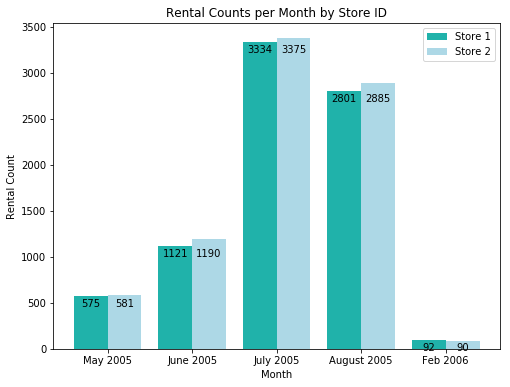

In [17]:
barWidth = 0.4

my_months = [5,6,7,8,2]
store_1 = [list(store_comp.loc[(store_comp['rental_month']==m) & (store_comp['store_id']==1)]['count_rentals'].values)[0] for m in my_months]
store_2 = [list(store_comp.loc[(store_comp['rental_month']==m) & (store_comp['store_id']==2)]['count_rentals'].values)[0] for m in my_months]
r1 = np.arange(len(store_1))
r2 = [x + barWidth for x in r1]
plt.figure(figsize=(8,6))
plt.bar(r1, store_1, color='lightseagreen', width=barWidth, label='Store 1',align='edge')
plt.bar(r2, store_2, color='lightblue', width=barWidth, label='Store 2',align='edge')
plt.xticks([r + barWidth for r in range(len(store_1))], ['May 2005','June 2005','July 2005','August 2005','Feb 2006'])
plt.legend()

plt.xlabel('Month')
plt.ylabel('Rental Count')
plt.title('Rental Counts per Month by Store ID')
for j in range(len(store_1)):
        text = store_1[j]
        pos = text-135
        plt.text(r1[j]+.2,pos,text,color='black',ha='center',va='bottom')
        text2 = store_2[j]
        pos2 = text-50
        plt.text(r2[j]+.2,pos,text2,color='black',ha='center',va='bottom')
plt.savefig('Visualizations/Q4_MonthlyRentalCountsPerStore.png', bbox_inches = "tight")
plt.show()

#### Question 4 Discussion:

For each month in 2005, Store 2 had more rentals than Store 1. In May, Store 2 had `6` more rentals than Store 1. Store 2 had `69` more rentals in June, `41` more rentals in July, and `84` more rentals in August. In Feburary 2006, Store 1 had `2` more rentals compared to Store 1. 

------
# Question 5
#### Who were the top 10 paying customers, how many payments did they make on a monthly basis during 2007, and what was the amount of the monthly payments?

Below is a query to capture the customer name, month and year of payment, and total payment amount for each month by these top 10 paying customers.

The results are sorted first by customer name and then for each month. The total amounts per month are listed for each customer.

In [18]:
top10_query= "SELECT f2.trunc_month, full_name, f2.pay_countpermon, f2.customer_amount \
FROM \
(SELECT f1.full_name AS full_name, \
sum(customer_amount) OVER (PARTITION BY f1.full_name) AS sum_customer, \
f1.trunc_month,f1.pay_countpermon,f1.customer_amount \
FROM \
(SELECT \
date_trunc('month',p.payment_date) AS trunc_month, \
concat(c.first_name,' ',c.last_name) AS full_name, \
count(c.first_name) AS pay_countpermon, \
sum(p.amount) AS customer_amount \
FROM payment p  \
JOIN customer c \
ON c.customer_id = p.customer_id \
WHERE EXTRACT(YEAR FROM date_trunc('month',p.payment_date))=2007 \
GROUP BY trunc_month,full_name) f1 \
ORDER BY sum_customer DESC) f2 \
WHERE full_name IN  \
( \
SELECT full_name \
FROM \
(SELECT \
date_trunc('month',p.payment_date) AS trunc_month, \
concat(c.first_name,' ',c.last_name) AS full_name, \
count(c.first_name) AS pay_countpermon, \
sum(p.amount) AS customer_amount \
FROM payment p  \
JOIN customer c \
ON c.customer_id = p.customer_id \
WHERE EXTRACT(YEAR FROM date_trunc('month',p.payment_date))=2007 \
GROUP BY trunc_month,full_name) f3 \
GROUP BY full_name \
ORDER BY sum(customer_amount) DESC \
LIMIT 10) \
ORDER BY full_name, trunc_month;"
top10 = pd.read_sql_query(top10_query, con=engine)
top10


,trunc_month,full_name,pay_countpermon,customer_amount
0,2007-02-01,Ana Bradley,4,19.96
1,2007-03-01,Ana Bradley,16,71.84
2,2007-04-01,Ana Bradley,12,72.88
3,2007-05-01,Ana Bradley,1,2.99
4,2007-02-01,Clara Shaw,6,22.94
5,2007-03-01,Clara Shaw,16,72.84
6,2007-04-01,Clara Shaw,18,93.82
7,2007-02-01,Curtis Irby,6,22.94
8,2007-03-01,Curtis Irby,17,86.83
9,2007-04-01,Curtis Irby,14,54.86


#### Plot a bar chart of each of the top 10 customers' purchase totals per month

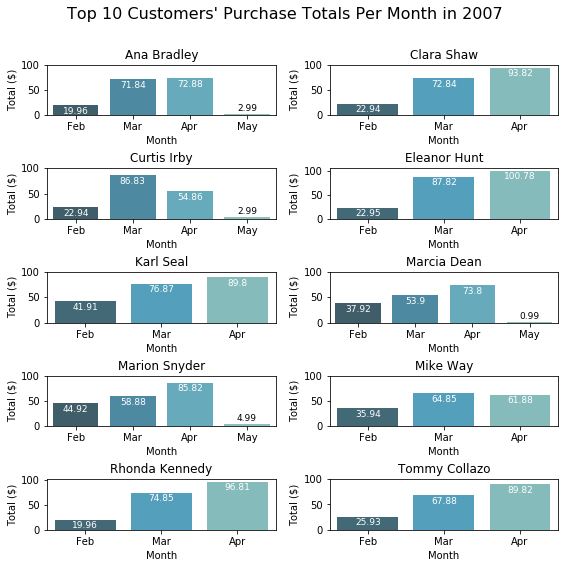

In [19]:
import seaborn as sns
unique_names_top10 = top10['full_name'].unique()
m=1
fig = plt.figure(figsize=(8,8))
fig.suptitle("Top 10 Customers' Purchase Totals Per Month in 2007", fontsize=16)

for u in unique_names_top10:
    plt.subplot(5,2,m)
    y = top10.loc[top10['full_name']==u]['customer_amount']
    x = top10.loc[top10['full_name']==u]['trunc_month'].map(lambda x: x.strftime("%b"))
    sns.barplot(x,y,palette="GnBu_d")
    plt.xlabel('Month')
    plt.yticks([0,50,100])

    plt.ylabel('Total ($)')
    plt.title(f"{u}")
    for j in range(len(y.values)):
        text = y.values[j]
        if text>=19:
            pos = y.values[j]-3
            plt.text(j,pos,text,color='white',ha='center',va='top',fontsize=9)
        else:
            pos = y.values[j]+20
            plt.text(j,pos,text,color='black',ha='center',va='top',fontsize=9)
    m+=1
plt.tight_layout()
fig.subplots_adjust(top=0.88)
plt.savefig('Visualizations/Q5_Top10Customers_MonthlyPurchaseTotals.png', bbox_inches = "tight")
plt.show()

#### Question 5 Discussion:
The top 10 paying customers in 2007 are Ana Bradley, Clara Shaw, Curtis Irby, Eleanor Hunt, Karl Seal, Marcia Dean, Marion Snyder, Mike Way, Rhonda Kennedy, and Tommy Collazo. 

Curtis Irby and Mike Way paid the most in March compared to the other months, whereas Ana Bradley, Clara Shaw, Elanor Hunt, Karl Seal, Marcia Dean, Marion Snyder, Rhonda Kennedy, and Tommy Collazo all paid the most in April compared to the other months.  

Moreover, Ana Bradley, Curtis Irby, Marcia Dean, and Marion Snyder all spent the least amount in May compared to the other months. Clara Shaw, Elenor Hunt, Karl Seal, Mike Way, Rhonda Kennedy, and Tommy Collazo all spent the least amount in February compared to the other months.

--------
# Question 6
#### What is  the difference across their monthly payments during 2007 for each of the top 10 paying customers? Who is the customer who paid the most difference in terms of payment?

Below is a query that compares the payment amounts in each successive month, repeated for each of the 10 paying customers, and finds the customer who paid the most difference in terms of payment.

In [20]:
top10_diff_most_query = "WITH top_10_customers (order_month, full_name,pay_count, customer_amount) \
AS \
(SELECT f2.trunc_month, full_name, f2.pay_countpermon, f2.customer_amount \
FROM \
(SELECT f1.full_name AS full_name, \
SUM(customer_amount) OVER (PARTITION BY f1.full_name) AS sum_customer, \
f1.trunc_month,f1.pay_countpermon,f1.customer_amount \
FROM \
(SELECT \
date_trunc('month',p.payment_date) AS trunc_month, \
concat(c.first_name,' ',c.last_name) AS full_name, \
COUNT(c.first_name) AS pay_countpermon, \
SUM(p.amount) AS customer_amount \
FROM payment p  \
JOIN customer c \
ON c.customer_id = p.customer_id \
WHERE EXTRACT(YEAR FROM date_trunc('month',p.payment_date))=2007 \
GROUP BY trunc_month,full_name) f1 \
ORDER BY sum_customer DESC) f2 \
WHERE full_name IN  \
(SELECT  \
full_name \
FROM \
(SELECT \
date_trunc('month',p.payment_date) AS trunc_month, \
concat(c.first_name,' ',c.last_name) AS full_name, \
COUNT(c.first_name) AS pay_countpermon, \
SUM(p.amount) AS customer_amount \
FROM payment p  \
JOIN customer c \
ON c.customer_id = p.customer_id \
WHERE EXTRACT(YEAR FROM date_trunc('month',p.payment_date))=2007 \
GROUP BY trunc_month,full_name) f3 \
GROUP BY full_name \
ORDER BY SUM(customer_amount) DESC \
LIMIT 10) \
ORDER BY full_name, trunc_month \
) \
\
SELECT full_name, order_month, MAX(monthly_payment_difference) \
FROM \
(SELECT order_month, full_name, pay_count, customer_amount, \
(customer_amount-lag(customer_amount) over (partition by full_name)) AS monthly_payment_difference \
FROM top_10_customers) f4 \
WHERE monthly_payment_difference IS NOT NULL \
GROUP BY full_name, order_month \
ORDER BY 3 DESC \
LIMIT 1;"
top10_diff_most = pd.read_sql_query(top10_diff_most_query, con=engine)
prev_month = (pd.to_datetime(top10_diff_most['order_month'][0])-pd.DateOffset(months=1)).strftime("%B")
print(f"The customer {top10_diff_most['full_name'].values[0]} paid the maximum difference of {top10_diff_most['max'].values[0]} dollars during {pd.to_datetime(top10_diff_most['order_month'].values[0]).strftime('%B')} 2007 from {prev_month} of 2007.")
top10_diff_most


The customer Eleanor Hunt paid the maximum difference of 64.87 dollars during March 2007 from February of 2007.


,full_name,order_month,max
0,Eleanor Hunt,2007-03-01,64.87


Below is a query that compares the payment amounts in each successive month, repeated for each of the 10 paying customers

In [21]:
top10_diff_all_query = "WITH top_10_customers (order_month, full_name,pay_count, customer_amount) \
AS \
(SELECT f2.trunc_month, full_name, f2.pay_countpermon, f2.customer_amount \
FROM \
(SELECT f1.full_name AS full_name, \
SUM(customer_amount) OVER (PARTITION BY f1.full_name) AS sum_customer, \
f1.trunc_month,f1.pay_countpermon,f1.customer_amount \
FROM \
(SELECT \
date_trunc('month',p.payment_date) AS trunc_month, \
concat(c.first_name,' ',c.last_name) AS full_name, \
COUNT(c.first_name) AS pay_countpermon, \
SUM(p.amount) AS customer_amount \
FROM payment p  \
JOIN customer c \
ON c.customer_id = p.customer_id \
WHERE EXTRACT(YEAR FROM date_trunc('month',p.payment_date))=2007 \
GROUP BY trunc_month,full_name) f1 \
ORDER BY sum_customer DESC) f2 \
WHERE full_name IN  \
(SELECT  \
full_name \
FROM \
(SELECT \
date_trunc('month',p.payment_date) AS trunc_month, \
concat(c.first_name,' ',c.last_name) AS full_name, \
COUNT(c.first_name) AS pay_countpermon, \
SUM(p.amount) AS customer_amount \
FROM payment p  \
JOIN customer c \
ON c.customer_id = p.customer_id \
WHERE EXTRACT(YEAR FROM date_trunc('month',p.payment_date))=2007 \
GROUP BY trunc_month,full_name) f3 \
GROUP BY full_name \
ORDER BY SUM(customer_amount) DESC \
LIMIT 10) \
ORDER BY full_name, trunc_month \
) \
\
SELECT full_name, order_month, MAX(monthly_payment_difference) \
FROM \
(SELECT order_month, full_name, pay_count, customer_amount, \
(customer_amount-lag(customer_amount) over (partition by full_name)) AS monthly_payment_difference \
FROM top_10_customers) f4 \
WHERE monthly_payment_difference IS NOT NULL \
GROUP BY full_name, order_month \
ORDER BY 3 DESC;"
top10_diff_all = pd.read_sql_query(top10_diff_all_query, con=engine)
top10_diff_all
top10_diff_all.to_csv('top10_diff_all.csv')

#### Plot each of the top 10 customers payment differences per month

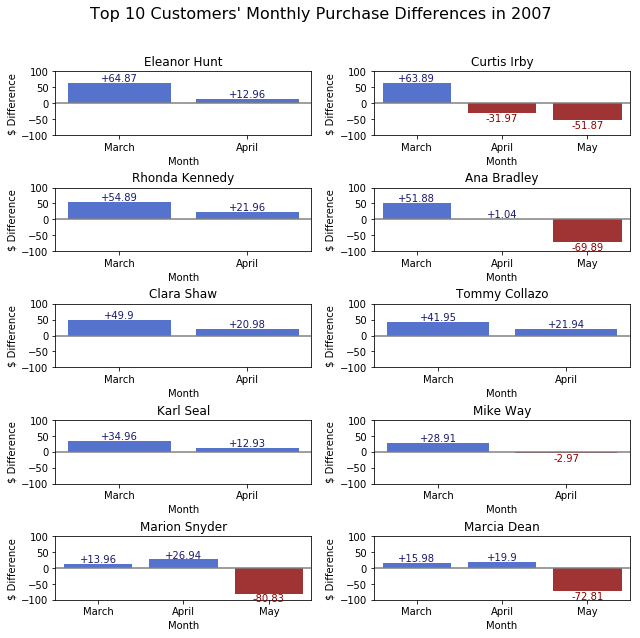

In [23]:
names = list(top10_diff_all['full_name'].unique())
m=1
fig = plt.figure(figsize=(9,9))
fig.suptitle("Top 10 Customers' Monthly Purchase Differences in 2007", fontsize=16)


for n in names:
    plt.subplot(5,2,m)
    current = top10_diff_all.loc[top10_diff_all['full_name']==n]
    current = current.sort_values(by='order_month')
    neg_vals = []
    for val in current['max']:
        if val<0:
            neg_vals.append(val)
        else:
            neg_vals.append(0)
    pos_vals = []
    for val in current['max']:
        if val>=0:
            pos_vals.append(val)
        else:
            pos_vals.append(0)
    current_date = current['order_month'].values
    c_date = [str(pd.to_datetime(current_date[i]).strftime("%B")) for i in range(len(current_date))]

    ax = sns.barplot(c_date,neg_vals,color='firebrick')
    sns.barplot(c_date,pos_vals,color='royalblue')
    ax.axhline(0,color='grey')
    plt.title(f"{n}")
    plt.yticks(np.arange(-100,125,50))
    plt.ylabel('$ Difference')
    plt.xlabel('Month')
    for j in range(len(current)):
        text = current['max'].iloc[j]
        if text>0:
            pos = text+30
            text = f"+{text}"
            plt.text(j,pos,text,color='midnightblue',ha='center',va='top')
        elif text < 0:
            if n == 'Marion Snyder':
                pos = text
            else:
                pos = text-1
            plt.text(j,pos,text,color='darkred',ha='center',va='top')
    m+=1

plt.tight_layout()
fig.subplots_adjust(top=0.88)
plt.savefig('Visualizations/Q6_Top10Customers_MonthlyPurchaseDifferences.png', bbox_inches = "tight")
plt.show()


#### Print the order month and the maximum difference for each of the top 10 customers

In [24]:
names = []
df = []
for i in range(len(top10_diff_all)):
    name=top10_diff_all['full_name'][i]
    if name not in names:
        names.append(name)
        df.append(top10_diff_all.iloc[i])
max_diff_all_custs = pd.DataFrame(df)
max_diff_all_custs=max_diff_all_custs.reset_index(drop=True)
max_diff_all_custs

,full_name,order_month,max
0,Eleanor Hunt,2007-03-01,64.87
1,Curtis Irby,2007-03-01,63.89
2,Rhonda Kennedy,2007-03-01,54.89
3,Ana Bradley,2007-03-01,51.88
4,Clara Shaw,2007-03-01,49.90
5,Tommy Collazo,2007-03-01,41.95
6,Karl Seal,2007-03-01,34.96
7,Mike Way,2007-03-01,28.91
8,Marion Snyder,2007-04-01,26.94
9,Marcia Dean,2007-04-01,19.90


#### Plot a bar chart of the maximum difference for each of the top 10 customers, and label the bar with the month in which the maximum difference occured

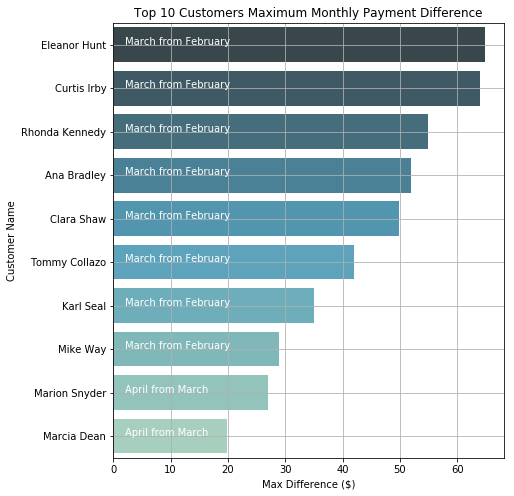

In [25]:
plt.figure(figsize=(7,8))
fig = sns.barplot(max_diff_all_custs['max'].values,max_diff_all_custs['full_name'].values,palette="GnBu_d")
plt.ylabel('Customer Name')
plt.xlabel('Max Difference ($)')
plt.title('Top 10 Customers Maximum Monthly Payment Difference')
for i in range(0,len(max_diff_all_custs['full_name'])):
    inc_month = str(pd.to_datetime(max_diff_all_custs['order_month'][i]).strftime("%B"))
    prev_month = str((pd.to_datetime(max_diff_all_custs['order_month'][i])-pd.DateOffset(months=1)).strftime("%B"))
    text = f'{inc_month} from {prev_month}'
    fig.text(2,i, text,color='white')
plt.grid()

plt.savefig('Visualizations/Q6_Top10Customers_Maximum_MonthlyPurchaseDifferences.png', bbox_inches = "tight")

plt.show()

#### Question 6 Discussion:

The customer Eleanor Hunt paid the maximum difference of `64.87` dollars during March 2007 from February of 2007.

Curtis Irby, Rhonda Kennedy, Ana Bradley, Clara Shaw, Tommy Collazo, Karl Seal, and Mike Way all paid their respective maximum differences during March 2007 from February of 2007, whereas Marion Snyder and Marcia Dean paid their respective maximum differences during April 2007 from March of 2007. 

Curtis Irby paid the second highest difference during March 2007 from February of 2007, but then paid less in April and May from March and April, respectively. Marion Snyder, Marcia Dean, and Ana Bradley all had negative monthly payment differences in May 2007 from April 2007.